# MODELO SARIMA e PREVISÕES

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs, nsdiffs
from scipy.stats import shapiro

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

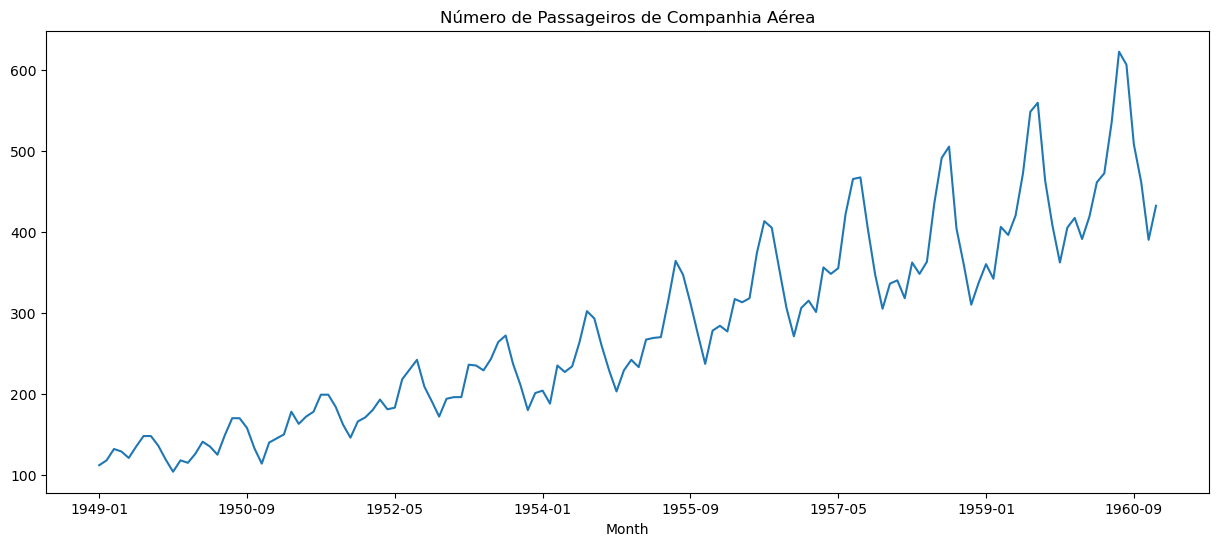

In [2]:
# Carregando a série AirPassengers
x = pd.read_csv('AirPassengers.csv', sep=',')
x = pd.Series(x['Passengers'].values, index = x['Month'])
x.plot(title='Número de Passageiros de Companhia Aérea')
plt.show()

In [3]:
# Verificando a estacionaridade da série
print('Teste KPSS original:')
kpss_stat, p_value, lags, critical_values = kpss(x)
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
print('Valores Críticos:')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')

Teste KPSS original:
Estatística do teste: 1.6513
p-valor: 0.0100
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\anail\AppData\Local\Temp\ipykernel_9564\1875451773.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(x)


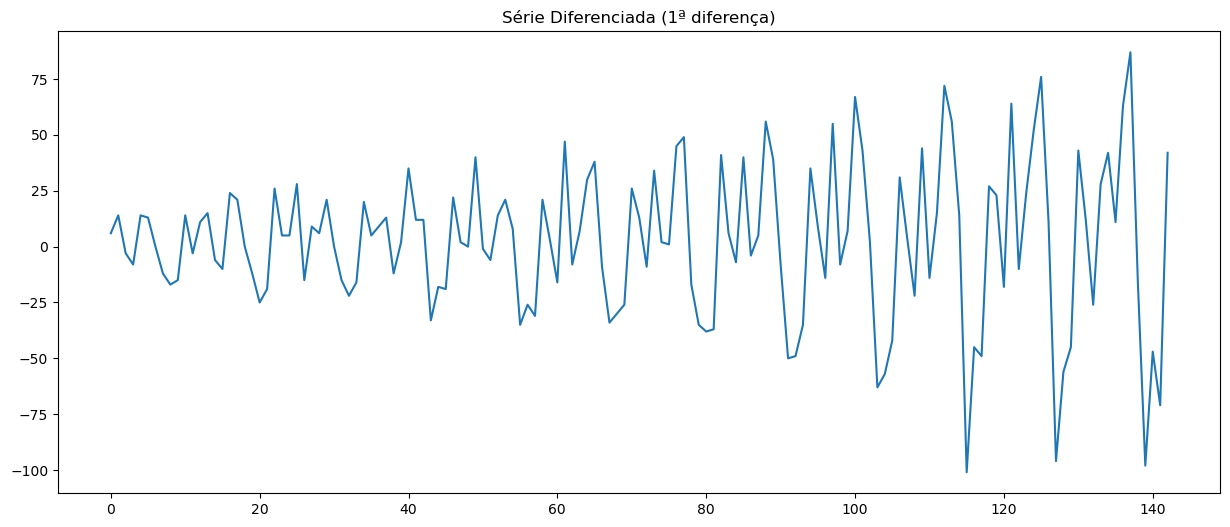

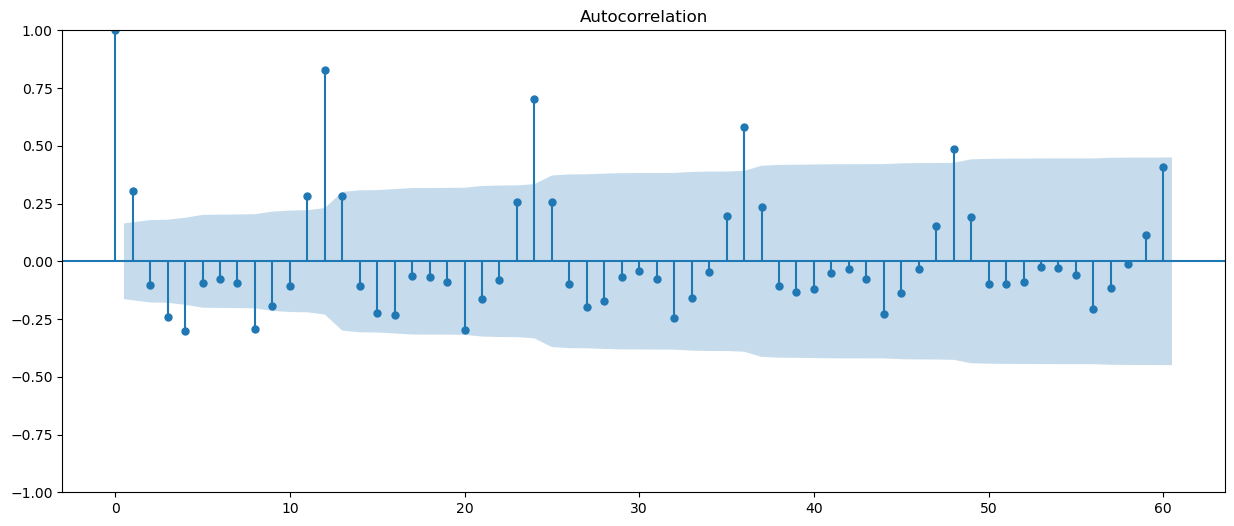

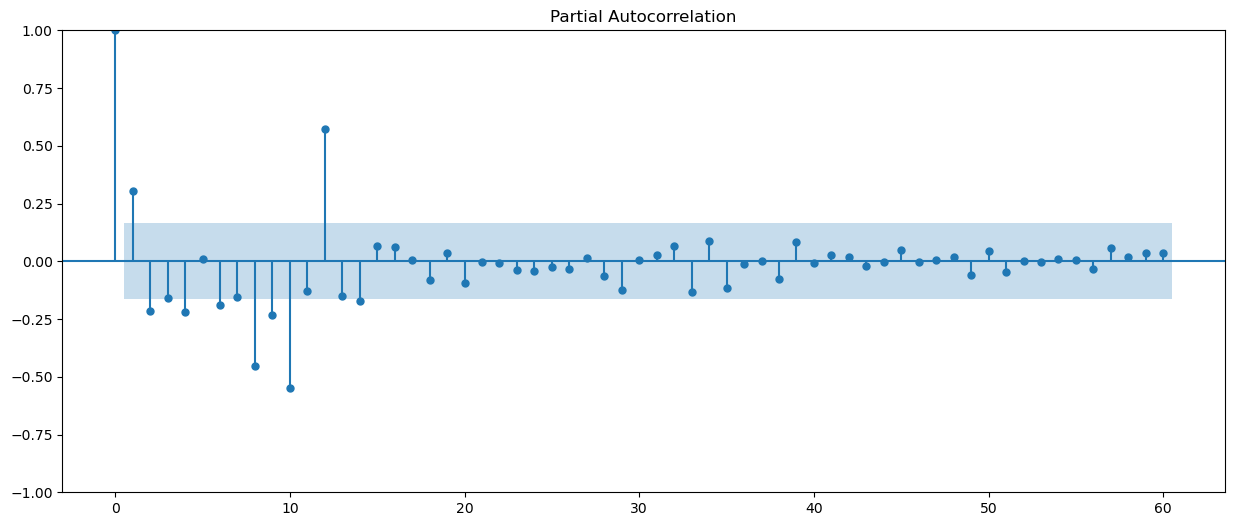

In [4]:
# Diferenciação simples
serie_dif = np.diff(x)
plt.plot(serie_dif)
plt.title('Série Diferenciada (1ª diferença)')
plt.show()
plot_acf(serie_dif, lags=5*12)
plt.show()
plot_pacf(serie_dif, lags=5*12)
plt.show()

In [5]:
# Verificando a estacionaridade da série diferenciada
print('Teste KPSS após 1ª diferenciação:')
kpss_stat, p_value, lags, critical_values = kpss(serie_dif)
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
print('Valores Críticos:')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')

Teste KPSS após 1ª diferenciação:
Estatística do teste: 0.0239
p-valor: 0.1000
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\anail\AppData\Local\Temp\ipykernel_9564\3591942788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(serie_dif)


In [6]:
# Verificando a necessidade de diferenciação sazonal
print('Número de diferenciações sazonais necessárias:')
nsdiff = nsdiffs(serie_dif, m=12)
print(nsdiff)

Número de diferenciações sazonais necessárias:
1


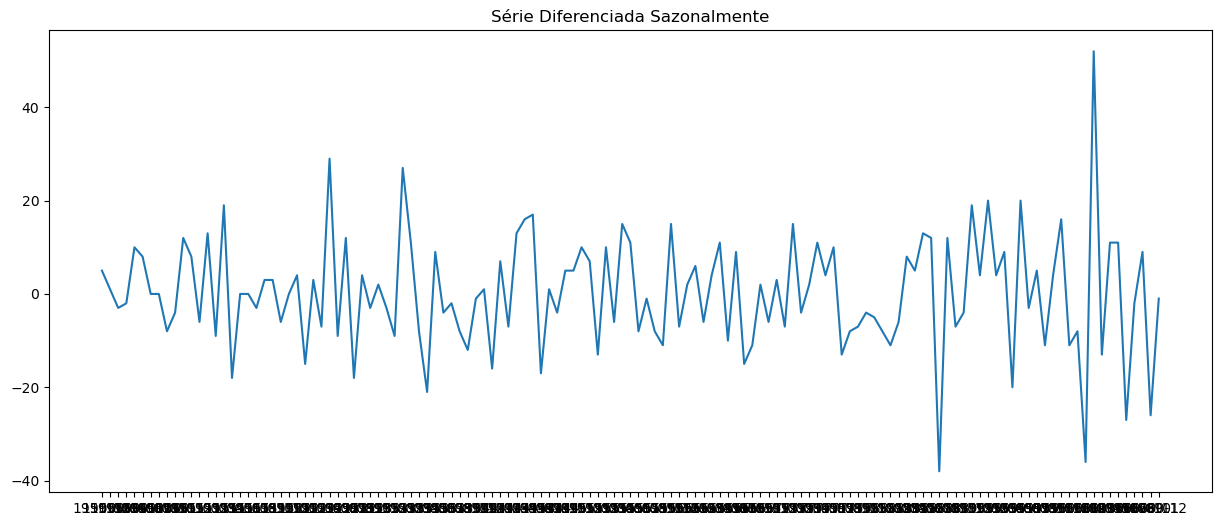

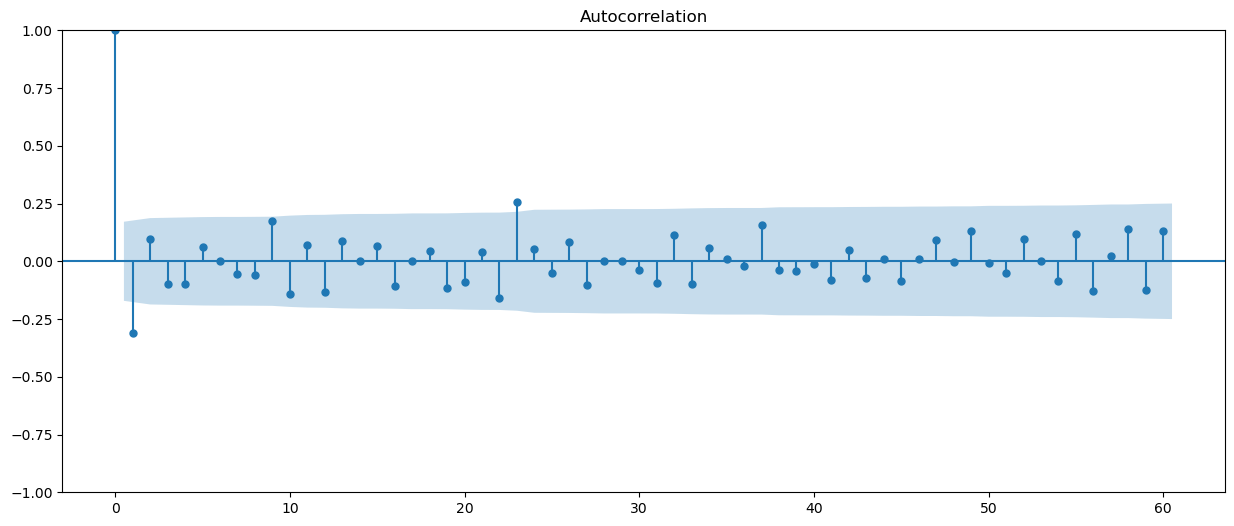

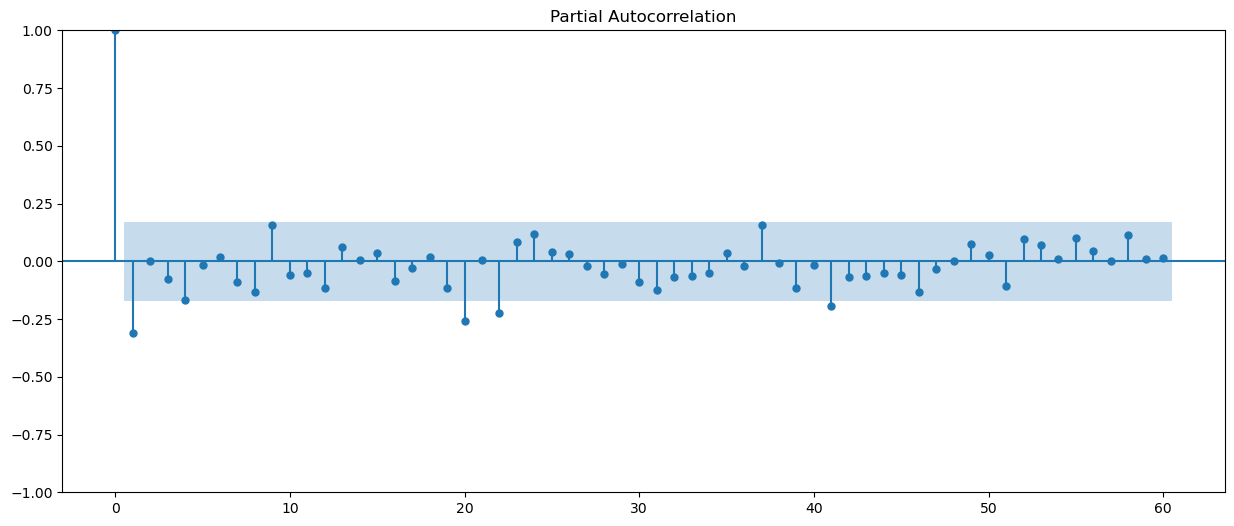

In [7]:
# Aplicando a diferenciação sazonal
serie_dif_s = x.diff().dropna().diff(12).dropna()
plt.plot(serie_dif_s)
plt.title('Série Diferenciada Sazonalmente')
plt.show()
plot_acf(serie_dif_s, lags=5*12)
plt.show()
plot_pacf(serie_dif_s, lags=5*12)
plt.show()

In [8]:
# Modelos Candidatos
# Modelo 1: SARIMA(1,1,0)x(0,1,0)
modelo1 = SARIMAX(x, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False).fit()
E_mod1 = modelo1.resid


C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


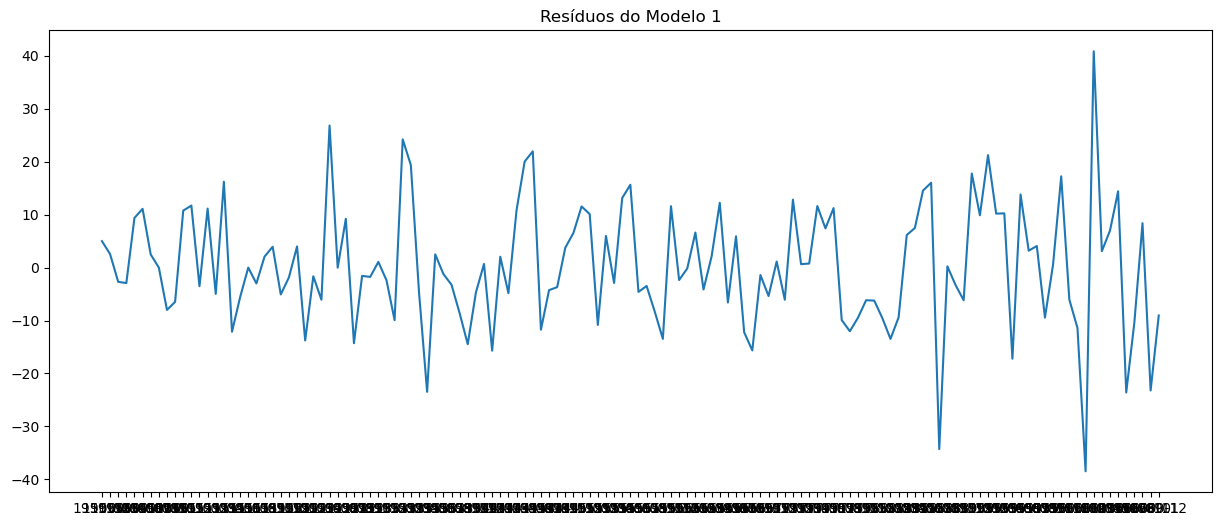

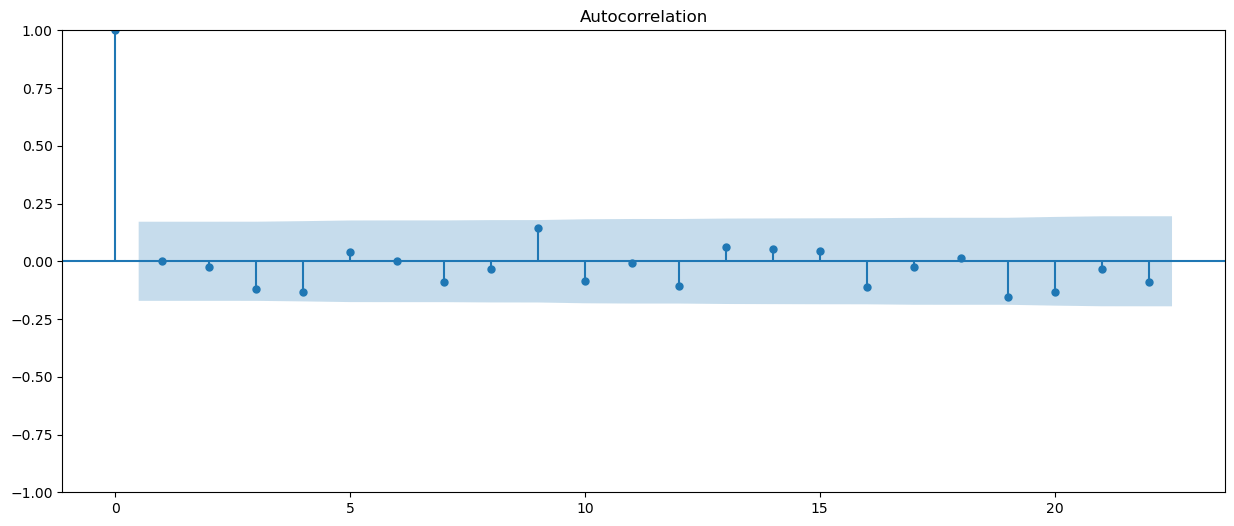

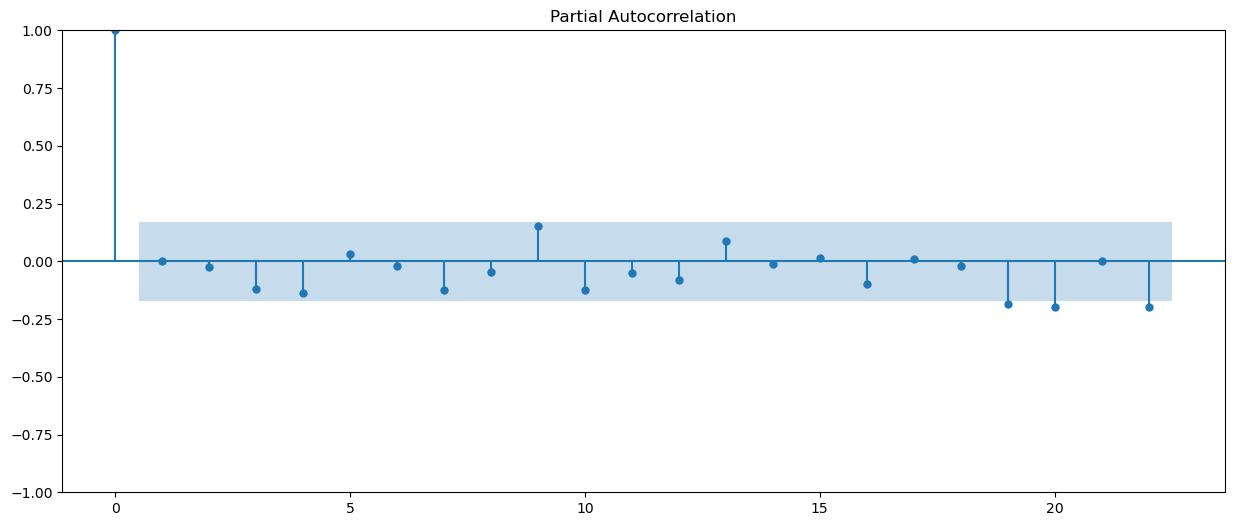

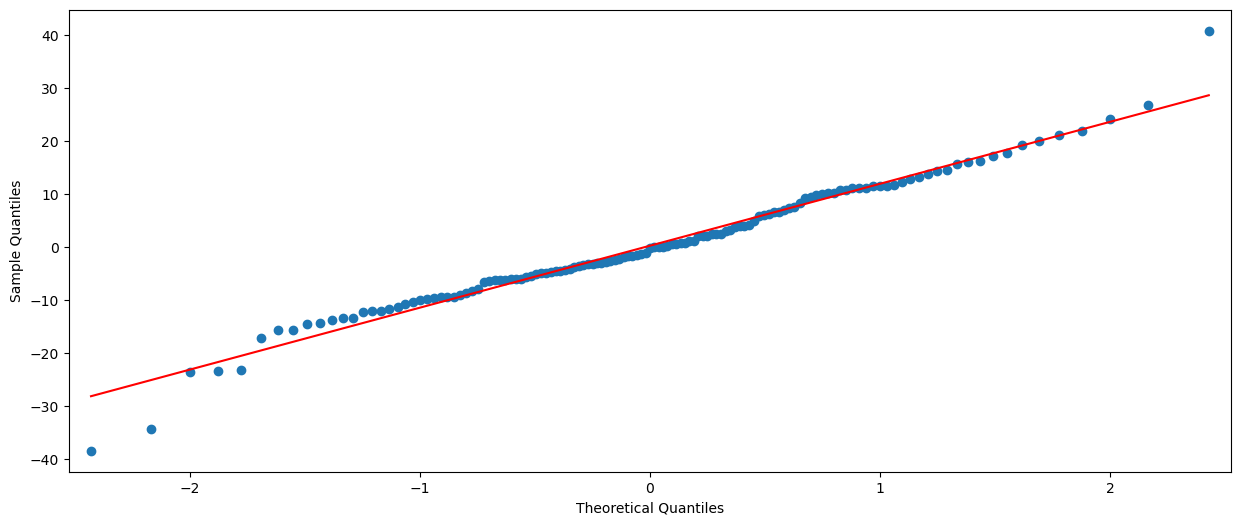

In [9]:
# Análise dos resíduos do Modelo 1
E_mod1 = E_mod1[13:]  # Removendo os primeiros 12 valores zero
plt.plot(E_mod1)
plt.title('Resíduos do Modelo 1')
plt.show()
plot_acf(E_mod1)
plt.show()
plot_pacf(E_mod1)
plt.show()
sm.qqplot(E_mod1, line='s')
plt.show()


In [10]:
# Testes Estatísticos dos Resíduos do Modelo 1
print('Teste KPSS para Resíduos do Modelo 1:')
kpss_stat, p_value, lags, critical_values = kpss(E_mod1)
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
print('Valores Críticos:')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')

Teste KPSS para Resíduos do Modelo 1:
Estatística do teste: 0.0485
p-valor: 0.1000
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\anail\AppData\Local\Temp\ipykernel_9564\2232985635.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(E_mod1)


In [11]:
print('Teste Ljung-Box para Resíduos do Modelo 1:')
ljung_box_result = sm.stats.acorr_ljungbox(E_mod1, lags=[15], return_df=True)
print(ljung_box_result)

Teste Ljung-Box para Resíduos do Modelo 1:
      lb_stat  lb_pvalue
15  12.983005   0.603611


In [12]:
print('Teste Shapiro-Wilk para Resíduos do Modelo 1:')
shapiro_stat, shapiro_p_value = shapiro(E_mod1)
print(f'Estatística do teste: {shapiro_stat:.4f}')
print(f'p-valor: {shapiro_p_value:.4f}')

Teste Shapiro-Wilk para Resíduos do Modelo 1:
Estatística do teste: 0.9832
p-valor: 0.1048


In [13]:
# Modelo 2: SARIMA(1,1,1)x(0,1,0)
modelo2 = SARIMAX(x, order=(1, 1, 1), seasonal_order=(0, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False).fit()
E_mod2 = modelo2.resid

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


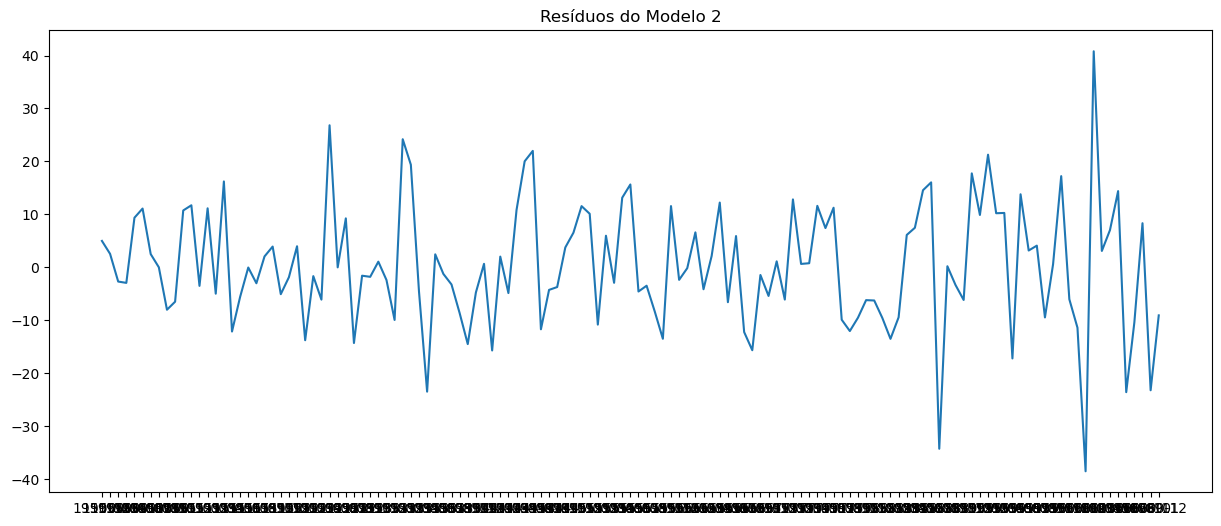

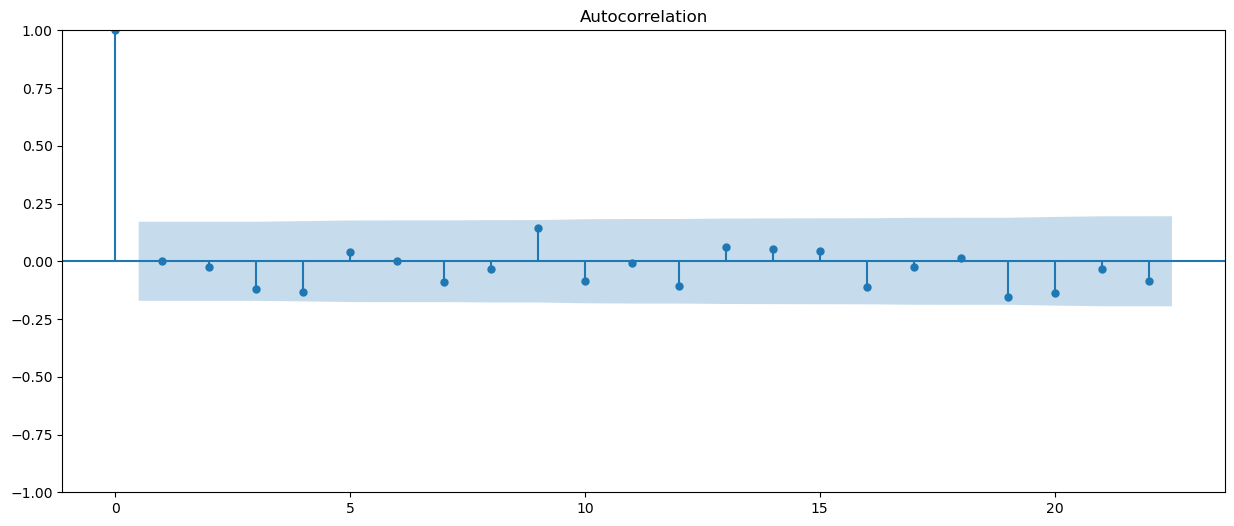

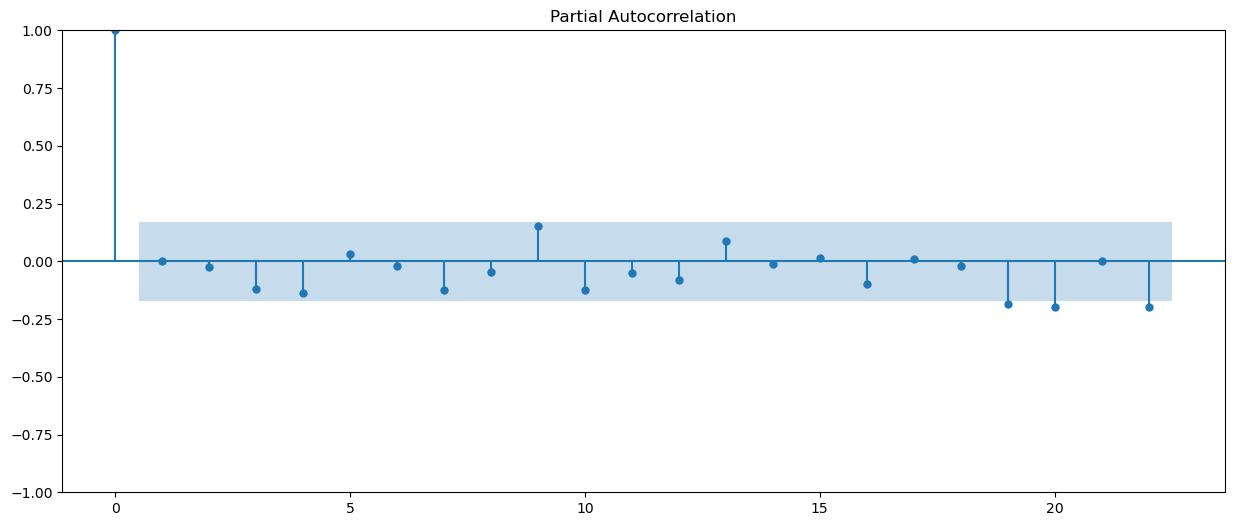

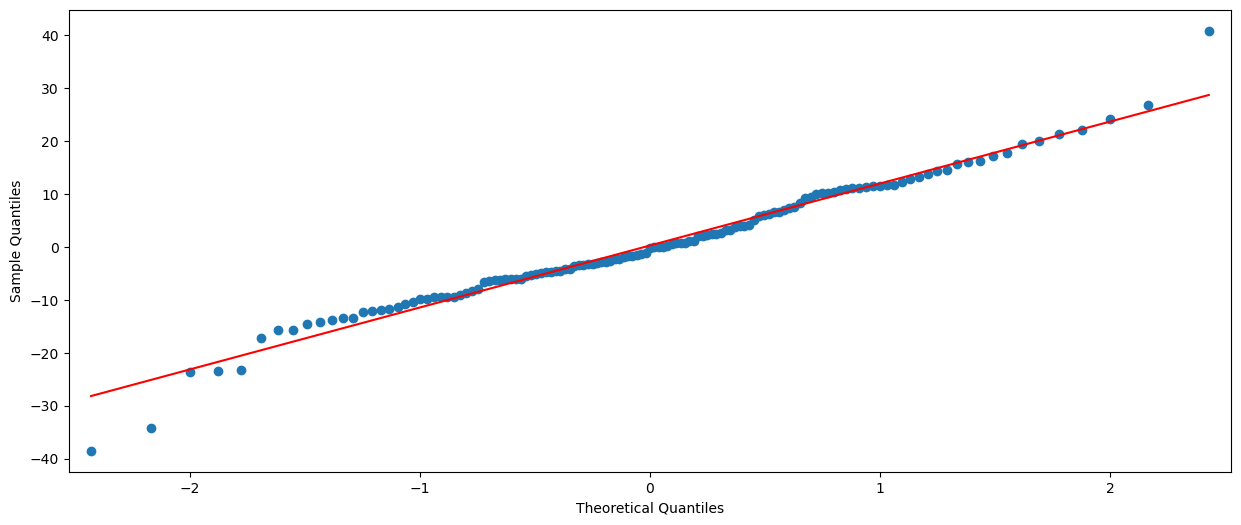

In [14]:
# Análise dos resíduos do Modelo 2
E_mod2 = E_mod2[13:]  # Removendo os primeiros 12 valores zero
plt.plot(E_mod2)
plt.title('Resíduos do Modelo 2')
plt.show()
plot_acf(E_mod2)
plt.show()
plot_pacf(E_mod2)
plt.show()
sm.qqplot(E_mod2, line='s')
plt.show()

In [15]:
print('Teste Ljung-Box para Resíduos do Modelo 2:')
ljung_box_result = sm.stats.acorr_ljungbox(E_mod2, lags=[15], return_df=True)
print(ljung_box_result)

Teste Ljung-Box para Resíduos do Modelo 2:
      lb_stat  lb_pvalue
15  12.982285   0.603666


In [16]:
print('Teste Shapiro-Wilk para Resíduos do Modelo 2:')
shapiro_stat, shapiro_p_value = shapiro(E_mod2)
print(f'Estatística do teste: {shapiro_stat:.4f}')
print(f'p-valor: {shapiro_p_value:.4f}')

Teste Shapiro-Wilk para Resíduos do Modelo 2:
Estatística do teste: 0.9832
p-valor: 0.1059


In [17]:
# Comparação dos Modelos

# Modelo 1: SARIMA(1,1,0)x(0,1,0)
print("\nModelo 1: SARIMA(1,1,0)x(0,1,0)")
print(modelo1.summary())


Modelo 1: SARIMA(1,1,0)x(0,1,0)
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -504.684
Date:                            Thu, 04 Jul 2024   AIC                           1013.368
Time:                                    23:47:21   BIC                           1019.103
Sample:                                01-01-1949   HQIC                          1015.698
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3096      0.074     -4.190      0.000      -0.454      -0.165
si

In [18]:
# Modelo 2: SARIMA(1,1,1)x(0,1,0)
print("\nModelo 2: SARIMA(1,1,1)x(0,1,0)")
print(modelo2.summary())


Modelo 2: SARIMA(1,1,1)x(0,1,0)
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -501.276
Date:                             Thu, 04 Jul 2024   AIC                           1008.553
Time:                                     23:47:24   BIC                           1017.132
Sample:                                 01-01-1949   HQIC                          1012.039
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3056      0.357     -0.856      0.392      -1.005       

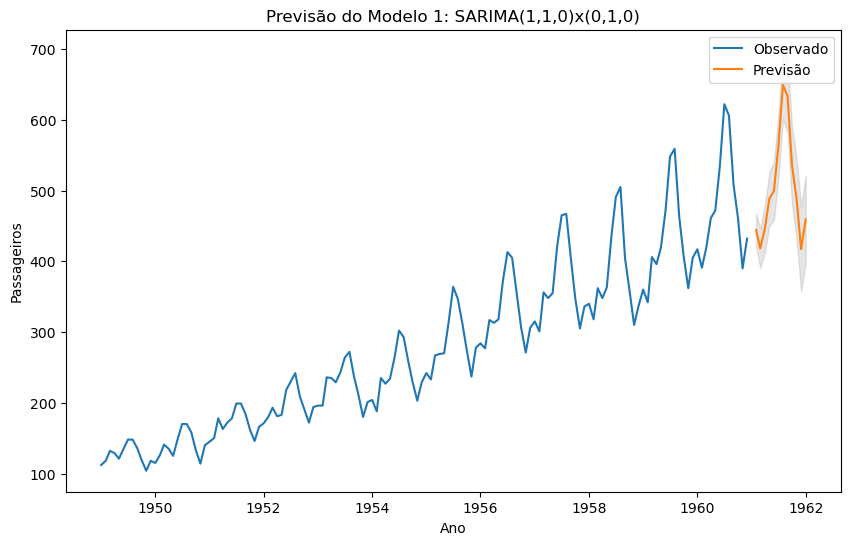

In [19]:
# Certifique-se de que o índice de x é um DatetimeIndex
x.index = pd.to_datetime(x.index)

# Previsão com o Modelo 1
forecast_steps = 12  # 1 ano de previsão
forecast_model1 = modelo1.get_forecast(steps=forecast_steps)
forecast_conf_int_model1 = forecast_model1.conf_int()

# Certifique-se de que os índices estão no mesmo formato
forecast_index_model1 = pd.date_range(start=x.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Plotando a previsão
plt.figure(figsize=(10, 6))
plt.plot(x, label='Observado')
plt.plot(forecast_index_model1, forecast_model1.predicted_mean, label='Previsão')
plt.fill_between(forecast_index_model1,
                 forecast_conf_int_model1.iloc[:, 0],
                 forecast_conf_int_model1.iloc[:, 1], color='gray', alpha=0.2)
plt.title('Previsão do Modelo 1: SARIMA(1,1,0)x(0,1,0)')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.legend()
plt.show()




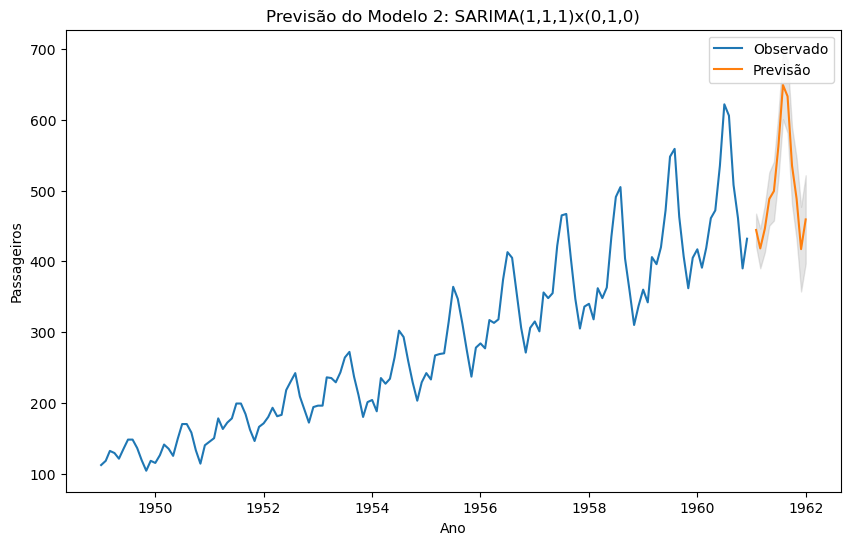

In [20]:
# Previsão com o Modelo 2
forecast_model2 = modelo2.get_forecast(steps=forecast_steps)
forecast_conf_int_model2 = forecast_model2.conf_int()

# Certifique-se de que os índices estão no mesmo formato
forecast_index_model2 = pd.date_range(start=x.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Plotando a previsão
plt.figure(figsize=(10, 6))
plt.plot(x, label='Observado')
plt.plot(forecast_index_model2, forecast_model2.predicted_mean, label='Previsão')
plt.fill_between(forecast_index_model2,
                 forecast_conf_int_model2.iloc[:, 0],
                 forecast_conf_int_model2.iloc[:, 1], color='gray', alpha=0.2)
plt.title('Previsão do Modelo 2: SARIMA(1,1,1)x(0,1,0)')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.legend()
plt.show()